In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob

trainval = pd.read_csv('../data/caterpillar/train_set.csv')
test = pd.read_csv('../data/caterpillar/test_set.csv')

trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()

from sklearn.model_selection import train_test_split
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42
)

train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

train.shape, val.shape, test.shape

((22628, 8), (7585, 8), (30235, 8))

In [3]:
import numpy as np

materials = pd.read_csv('../data/caterpillar/bill_of_materials.csv')

materials_melted = pd.DataFrame(
    columns=['tube_assembly_id', 'component_id', 'quantity'])

for i in range(1, 9):
    component_id_i = 'component_id_' + str(i)
    quantity_i = 'quantity_' + str(i)
    materials_i = materials.melt(id_vars=['tube_assembly_id',
                                          component_id_i],
                                 value_vars=[quantity_i], 
                                 value_name='quantity').drop(
        columns='variable').rename(
        columns={component_id_i: 'component_id'})
    materials_melted = materials_melted.append(materials_i,
                                               ignore_index=True)    
    
materials = pd.pivot_table(materials_melted,
                           values='quantity',
                           columns='component_id',
                           index='tube_assembly_id'
                          ).reset_index().rename_axis('', axis='columns')

component_ids = list(materials.columns)[1:]

materials = materials.fillna(0)
counts = materials[component_ids].astype(int)
materials['Total'] = counts.sum(axis=1)
materials['Distinct'] = counts.gt(0).sum(axis=1)

large_count = counts.drop([col for col, val in counts.gt(0).sum().iteritems()
                      if val < 20], axis=1)

materials = pd.concat([materials['tube_assembly_id'],
                       large_count,
                       materials['Total'],
                       materials['Distinct']], axis=1)

materials

,tube_assembly_id,C-0001,C-0002,C-0003,C-0004,C-0007,C-0057,C-0071,C-0074,C-0095,...,C-2004,C-2005,C-2019,C-2027,C-2028,C-2029,C-2030,C-2032,Total,Distinct
0,TA-00001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,2
1,TA-00002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
2,TA-00003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
3,TA-00004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
4,TA-00005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,3
5,TA-00006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,3
6,TA-00007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,2
7,TA-00008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
8,TA-00009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,2
9,TA-00010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1


In [4]:
def wrangle(data):
    data = data.copy()
    
    # Engineer date features
    data['quote_date'] = pd.to_datetime(data['quote_date'], infer_datetime_format=True)
    data['quote_date_year'] = data['quote_date'].dt.year
    data['quote_date_month'] = data['quote_date'].dt.month
    data = data.drop(columns='quote_date')
    
    # Merge data
    tube = pd.read_csv('../data/caterpillar/tube.csv')
    specs = pd.read_csv('../data/caterpillar/specs.csv')
    data = data.merge(tube, how='left')
    data = data.merge(materials, how='left')
    data = data.merge(specs, how='left')

    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    data = data.drop(columns='tube_assembly_id')
    
    return data

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

print(train.shape, val.shape, test.shape)

(22628, 192) (7585, 192) (30235, 192)


In [5]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

target = 'cost'

X_train = train.drop(columns=target)
X_val = val.drop(columns=target)

y_train = train[target]
y_val = val[target]

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(max_depth=7,
                 n_estimators=1000,
                 n_jobs=-1,
                 gamma=.05,
                 colsample_bytree=.3,
                 reg_alpha=.1,
                 reg_lambda=.95,
                 objective='reg:squarederror')
)

pipeline.fit(X_train, np.array(y_train_log))
y_train_pred_log = pipeline.predict(X_train)
y_val_pred_log = pipeline.predict(X_val)

print(rmse(y_train_log, y_train_pred_log))
print(rmse(y_val_log, y_val_pred_log))

coefficients = pd.Series(pipeline[1].feature_importances_,
                         X_train.columns.tolist())
plt.style.use('dark_background')
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');
plt.show()

0.09400137979619257
0.24852837609614065


<Figure size 1000x3000 with 1 Axes>

[0]	validation_0-rmse:1.72799	validation_1-rmse:1.71927
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.5841	validation_1-rmse:1.57882
[2]	validation_0-rmse:1.45741	validation_1-rmse:1.45294
[3]	validation_0-rmse:1.34581	validation_1-rmse:1.34284
[4]	validation_0-rmse:1.24439	validation_1-rmse:1.2437
[5]	validation_0-rmse:1.15433	validation_1-rmse:1.15698
[6]	validation_0-rmse:1.05162	validation_1-rmse:1.05579
[7]	validation_0-rmse:0.959419	validation_1-rmse:0.965747
[8]	validation_0-rmse:0.879315	validation_1-rmse:0.887315
[9]	validation_0-rmse:0.824066	validation_1-rmse:0.834289
[10]	validation_0-rmse:0.775458	validation_1-rmse:0.787886
[11]	validation_0-rmse:0.734392	validation_1-rmse:0.749075
[12]	validation_0-rmse:0.695978	validation_1-rmse:0.713098
[13]	validation_0-rmse:0.64181	validation_1-rmse:0.660909
[14]	validation_0-rmse:0.613222	validation

[137]	validation_0-rmse:0.168538	validation_1-rmse:0.269039
[138]	validation_0-rmse:0.168348	validation_1-rmse:0.268997
[139]	validation_0-rmse:0.168011	validation_1-rmse:0.268757
[140]	validation_0-rmse:0.167232	validation_1-rmse:0.268627
[141]	validation_0-rmse:0.167189	validation_1-rmse:0.268613
[142]	validation_0-rmse:0.166609	validation_1-rmse:0.268325
[143]	validation_0-rmse:0.166514	validation_1-rmse:0.268242
[144]	validation_0-rmse:0.166021	validation_1-rmse:0.267987
[145]	validation_0-rmse:0.165972	validation_1-rmse:0.267976
[146]	validation_0-rmse:0.165824	validation_1-rmse:0.267954
[147]	validation_0-rmse:0.165684	validation_1-rmse:0.2679
[148]	validation_0-rmse:0.164949	validation_1-rmse:0.267642
[149]	validation_0-rmse:0.164424	validation_1-rmse:0.267201
[150]	validation_0-rmse:0.164286	validation_1-rmse:0.267113
[151]	validation_0-rmse:0.163687	validation_1-rmse:0.267087
[152]	validation_0-rmse:0.163111	validation_1-rmse:0.266668
[153]	validation_0-rmse:0.162686	validatio

[274]	validation_0-rmse:0.138744	validation_1-rmse:0.258584
[275]	validation_0-rmse:0.138685	validation_1-rmse:0.25858
[276]	validation_0-rmse:0.138486	validation_1-rmse:0.258548
[277]	validation_0-rmse:0.138266	validation_1-rmse:0.258533
[278]	validation_0-rmse:0.13823	validation_1-rmse:0.258528
[279]	validation_0-rmse:0.138045	validation_1-rmse:0.258562
[280]	validation_0-rmse:0.137932	validation_1-rmse:0.258582
[281]	validation_0-rmse:0.137844	validation_1-rmse:0.258564
[282]	validation_0-rmse:0.137662	validation_1-rmse:0.258494
[283]	validation_0-rmse:0.137588	validation_1-rmse:0.258458
[284]	validation_0-rmse:0.13757	validation_1-rmse:0.258437
[285]	validation_0-rmse:0.137518	validation_1-rmse:0.258434
[286]	validation_0-rmse:0.137495	validation_1-rmse:0.258427
[287]	validation_0-rmse:0.137399	validation_1-rmse:0.258401
[288]	validation_0-rmse:0.136744	validation_1-rmse:0.257823
[289]	validation_0-rmse:0.136725	validation_1-rmse:0.257808
[290]	validation_0-rmse:0.136377	validation

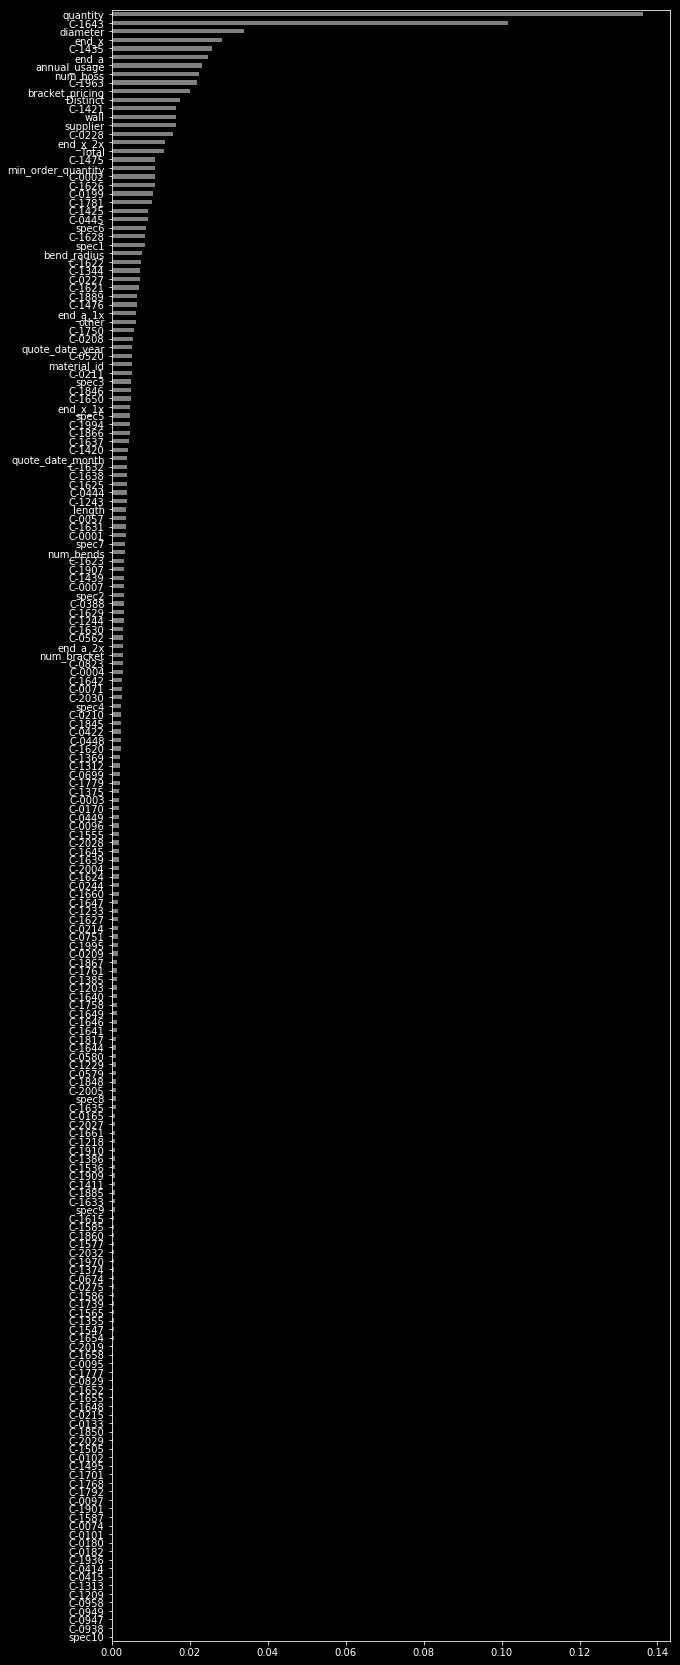

In [12]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

eval_set = [(X_train_encoded, y_train_log), 
            (X_val_encoded, y_val_log)]

model = XGBRegressor(max_depth=7,
                 n_estimators=1000,
                 n_jobs=-1,
                 gamma=.05,
                 colsample_bytree=.3,
                 reg_alpha=.1,
                 reg_lambda=.95,
                 objective='reg:squarederror')
model.fit(X_train_encoded, np.array(y_train_log), 
          early_stopping_rounds=10, eval_metric='rmse', 
          eval_set=eval_set)

y_train_pred_log = model.predict(X_train_encoded)
y_val_pred_log = model.predict(X_val_encoded)

coefficients = pd.Series(model.feature_importances_,
                         X_train.columns.tolist())
plt.style.use('dark_background')
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');
plt.show()

In [16]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=1000,
                 n_jobs=-1,
                 objective='reg:squarederror')
)

param_distributions = {
    'xgbregressor__max_depth': randint(4, 10),
    'xgbregressor__gamma': uniform(0, .5),
    'xgbregressor__colsample_bytree': uniform(0, .5),
    'xgbregressor__reg_alpha': uniform(0, .5),
    'xgbregressor__reg_lambda': uniform(.5, 1),
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, np.array(y_train_log));

print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  5.4min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  5.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  7.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.6min finished


Best hyperparameters {'xgbregressor__colsample_bytree': 0.4915953679824354, 'xgbregressor__gamma': 0.15386150389482162, 'xgbregressor__max_depth': 8, 'xgbregressor__reg_alpha': 0.2159237613132125, 'xgbregressor__reg_lambda': 0.5387907614313046}
Cross-validation RMSLE 0.33222337487627007


In [7]:
X_test = test.drop(columns='id')
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)

sample_submission = pd.read_csv('../data/caterpillar/sample_submission.csv')

submission = sample_submission.copy()
submission['cost'] = y_pred
submission.to_csv('nathan_van_wyck_submission.csv', index=False)